<a href="https://colab.research.google.com/github/dalexa10/Python_Data_Science/blob/main/Defect_Detection_with_Images/bowtie_tutorial_day_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Defect ID using statistical learning methods

**Part 1: Acquiring the IR-GFP Data**

Depending on the source, data will be stored in different formats.  
In this case, the data is from DeltaVision's software and is stored in .dt1 files.
Each file consists of a header with several flags marked with '@**@flag_name'.
The final flag is '@**@data' which is followed by a 307,200 pixel values.

These represent 3 flattened images: the Light Image (IR-Transmission), Shear0, and Shear45 images.

This first part of this script: 

*   Reads .dt1 files
*   Parses the data for the 3 images data specifically.
*   Reshapes the flattened arrays into images.
*   Displays and / or saves the images.


First, get everything you need from github:

In [1]:
!git clone https://github.com/dalexa10/bowtie_tutorial

Cloning into 'bowtie_tutorial'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 306 (delta 8), reused 0 (delta 0), pack-reused 288
Receiving objects: 100% (306/306), 199.94 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (249/249), done.


Now, read the data files:

In [2]:
import array

import numpy as np
import matplotlib.pyplot as plt
import glob

def get_images(filename, xdim = 640, ydim = 480):
    """
    Parses .dt1 file to extract 3 images.
    Returns Light Image, Shear0 Image, Shear45 Image in the form of numpy arrays.
    """
    filestring = open(filename,"rb").read()
    
    # Image data begins 34 bytes after the '@**@Data' flag
    idx = filestring.rfind(b'@**@Data')
    splitstring = filestring[idx+34:]
    f = array.array('f')
    #f.fromstring(splitstring)
    f.frombytes(splitstring)
    f = np.asarray(f)

    # Separate into 3 image types IR Transmission (Light), Shear0, and Shear 45
    imgLight = f[:xdim*ydim].reshape(ydim, xdim)

    # Shear 45 Image (must be normalized by light image)
    img45 = f[xdim*ydim: 2*xdim*ydim].reshape(ydim, xdim)
    with np.errstate(divide='ignore', invalid='ignore'):
        img45 = np.true_divide(img45,imgLight)
        img45[img45 == np.inf] = 1
        img45 = np.nan_to_num(img45)
        
    # Shear 0 Image (must be normalized by light image)
    img0 = f[2*xdim*ydim:3*xdim*ydim].reshape(ydim,xdim)        
    with np.errstate(divide='ignore', invalid='ignore'):
        img0 = np.true_divide(img0,imgLight)
        img0[img0 == np.inf] = 1
        img0 = np.nan_to_num(img0)
    
    return imgLight, img0, img45

...having obtained the data, we now plot the images:

In [3]:
def show_images(imgL, img0, img45):
    """Plots Light, Shear0 and Shear45 images in grayscale."""
    plt.gray() 
    plt.figure('Light')
    plt.imshow(imgL)
    plt.title("IR Transmission")
    plt.figure('Shear 0')
    plt.imshow(img0)
    plt.title("Shear 0")
    plt.figure('Shear 45')
    plt.imshow(img45)
    plt.title("Shear 45")

Now we save the image files:

In [4]:
def save_images(file_names, save_file = "/content/bowtie_tutorial/images/5x_images/"):
    """Saves a copy of each image."""
    for i, file in enumerate(file_names):
        print('Saving',i,'/',len(file_names))
        imgL, img0, img45 = get_images(file)
        plt.imsave(f'{save_file}{i}_Light.png', imgL)
        plt.imsave(f'{save_file}{i}_Shear0.png', img0)
        plt.imsave(f'{save_file}{i}_Shear45.png', img45)

...and display one set of Light, Shear 0, and Shear 45 images.

Saving 0 / 25
Saving 1 / 25
Saving 2 / 25
Saving 3 / 25
Saving 4 / 25
Saving 5 / 25
Saving 6 / 25
Saving 7 / 25
Saving 8 / 25
Saving 9 / 25
Saving 10 / 25
Saving 11 / 25
Saving 12 / 25
Saving 13 / 25
Saving 14 / 25
Saving 15 / 25
Saving 16 / 25
Saving 17 / 25
Saving 18 / 25
Saving 19 / 25
Saving 20 / 25
Saving 21 / 25
Saving 22 / 25
Saving 23 / 25
Saving 24 / 25


<Figure size 432x288 with 0 Axes>

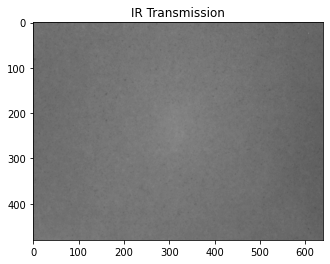

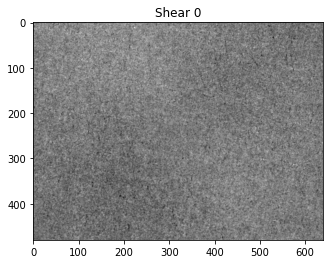

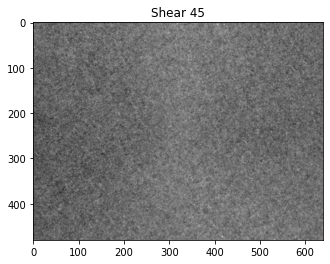

In [5]:
if __name__ == "__main__":
    plt.close('all')
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1')
    IMAGE_NUMBER = 0 # choose an image to view from 0 to 24
    imgL, img0, img45 = get_images(FILES[IMAGE_NUMBER])
    show_images(imgL, img0, img45)
    save_images(FILES)

**Part 2: Cleaning the GFP Data**

Most datasets have some form of undesired artifacts.
One such artifact in this dataset is hypersensitive pixels.
A hypersensitive pixel is a pixel that regularly has a value
much higher than the other pixels in the image.  They arise
due to thermal effects in the detector.  
Given their nature, they can be easily identified by recording the
most intense pixel in a sample of images. 

Given the number of pixels in the image, the number of images, 
and assuming all pixels have a roughly equal probability of being
the most intense pixel in the image, we can predict the probability
of any pixel occuring as the most intense pixel N times and replace
those pixels that occur as the most intense pixel too frequently.
Replacement can be done by resetting the value of the pixel value to the mean value of the neighboring pixels.
This process can be done recursively since replacing one hot pixel may reveal another.
Take a look at the images in ./images/5x_images.  Can you spot a hypersensitive pixel?

First we look for hot pixels and mark their coordinates.  Then we replace them, and plot the "before" and "after" images.

Inspecting 0 / 25
Inspecting 1 / 25
Inspecting 2 / 25
Inspecting 3 / 25
Inspecting 4 / 25
Inspecting 5 / 25
Inspecting 6 / 25
Inspecting 7 / 25
Inspecting 8 / 25
Inspecting 9 / 25
Inspecting 10 / 25
Inspecting 11 / 25
Inspecting 12 / 25
Inspecting 13 / 25
Inspecting 14 / 25
Inspecting 15 / 25
Inspecting 16 / 25
Inspecting 17 / 25
Inspecting 18 / 25
Inspecting 19 / 25
Inspecting 20 / 25
Inspecting 21 / 25
Inspecting 22 / 25
Inspecting 23 / 25
Inspecting 24 / 25

Light
Counter({15968: 25})

Shear0
Counter({16875: 1, 97894: 1, 4599: 1, 134997: 1, 27639: 1, 93659: 1, 91569: 1, 139214: 1, 62797: 1, 174743: 1, 140098: 1, 224471: 1, 65451: 1, 7903: 1, 28279: 1, 72209: 1, 4707: 1, 76317: 1, 16375: 1, 37706: 1, 126521: 1, 25859: 1, 228294: 1, 54512: 1, 40468: 1})

Shear45
Counter({15546: 2, 1244: 1, 260325: 1, 70513: 1, 11081: 1, 190545: 1, 197545: 1, 287713: 1, 1680: 1, 14826: 1, 19393: 1, 80976: 1, 34822: 1, 302497: 1, 28279: 1, 132635: 1, 175819: 1, 244617: 1, 262533: 1, 289066: 1, 197300: 1

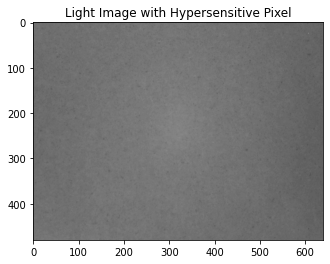

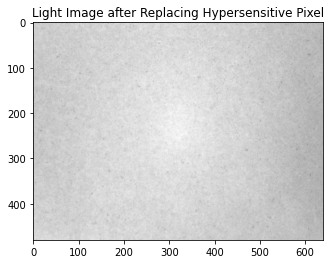

In [ ]:
import collections


def find_hot_pixels(file_names):
    """Keeps track of how many times each pixel occurred as the most intense pixel in each image."""
    counter = {'Light': collections.Counter(),
             'Shear0': collections.Counter(),
             'Shear45': collections.Counter()
             }
    for i, file in enumerate(file_names):
        print('Inspecting',i,'/',len(file_names))
        imgL, img0, img45 = get_images(file)
        counter['Light'][np.argmax(imgL)] += 1
        counter['Shear0'][np.argmax(img0)] += 1
        counter['Shear45'][np.argmax(img45)] += 1
    print()
    return counter

def pixel_to_xy(pixel, xdim=640):
    """
    Takes pixel index and returns tuple of (x, y) coordinates. 
    y+ axis is down, x+ axis is right, and (0, 0) is the top left corner.
    """
    return (pixel%xdim, pixel//xdim)

def replace_hot_pixels(image, hot_pixels, xdim=640, ydim=480):
    """Replaces hot pixels with the mean of their 8-directionally adjacent neighbors"""
    for pixel in hot_pixels:
        x, y = pixel_to_xy(pixel)
        neighbors = []
        for i in range(max(0, y-1), min(y+2, ydim)):
            for j in range(max(0, x-1), min(x+2, xdim)):
                if i != j:
                    neighbors.append(image[i][j])
        image[y][x] = sum(neighbors) / len(neighbors) if neighbors else 0
    return image
        
if __name__ == "__main__":
    plt.close('all')
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1')
    
    # Count how many times each pixel occurs as the most intense pixel in an image
    counter = find_hot_pixels(FILES)
    for key in counter:
        print(key)
        print(counter[key])
        print()
        
    print("Suspect:", pixel_to_xy(list(counter['Light'].keys()).pop()))
    print("Suspect:", pixel_to_xy(15546))
    
    # Inspect image before replacing pixel
    imgL, img0, img45 = get_images(FILES[0])
    plt.figure(1)
    plt.imshow(imgL)
    plt.title("Light Image with Hypersensitive Pixel")
    
    # Replace the hot pixels
    hot_pixels = [15968, 15546]
    imgL = replace_hot_pixels(imgL, hot_pixels)
    
    # Inspect image after replacing hot pixel (notice the contrast change)
    plt.figure(2)
    plt.imshow(imgL)    
    plt.title("Light Image after Replacing Hypersensitive Pixel")

Imperfections in the light source, optic path, and detector can result in optical aberrations.
When an aberration is consistently present in the same location, across all images, while the other 
features on the image change, then a subtraction image can be used to remove the optical aberration.

Given the limited data in this tutorial, we will use all of the provided images to create
a subtraction image.  
We will create one subtraction image for the shear 0 images, and one for the shear 45 images.
This is done by simply averaging all of the images, or:

sub0[i][j] = sum(img0[i][j] for img0 in all_shear0_images) / number_of_shear0_images

Then we can subtract the subtraction image from the raw image.

Subtraction images are not perfect.  They can be used to remove consistent optical aberrations
from an image, but they also affect the remaining pixel values.  Consider what additional information
in the image may be lost or altered when applying a subtraction image.  

0 / 25
1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25


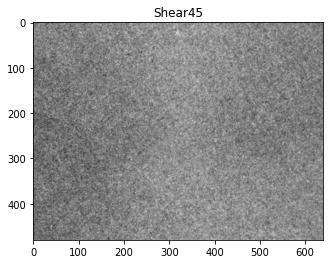

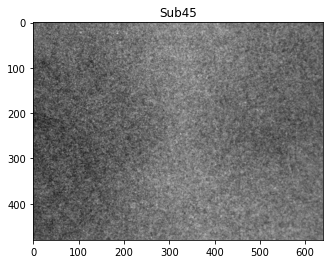

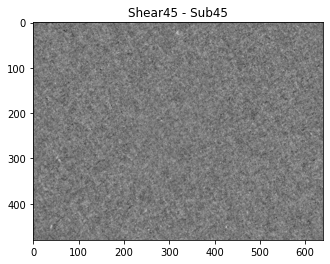

In [ ]:
def create_subtraction_images(file_names, xdim=640, ydim=480):
    """Creates 2 subtraction images by averaging all shear0 and shear45 images."""
    sub0 = np.zeros((ydim, xdim))
    sub45 = np.zeros((ydim, xdim))
    for i, file_name in enumerate(file_names):
        print(i,'/',len(file_names))
        imgL, img0, img45 = get_images(file_name)
        sub0 += img0
        sub45 += img45
    return sub0 / len(file_names), sub45 / len(file_names)

if __name__ == "__main__":
    plt.close('all')
    FILES = glob.glob('/content/bowtie_tutorial/Wafer_Data_Files/*.dt1') # get a list of the path to each .dt1 file
    
    # Pick an image between 0 and 24
    IMAGE_NUMBER = 20
    
    # Show raw Images
    imgL, img0, img45 = get_images(FILES[IMAGE_NUMBER])
    plt.figure(0)
    plt.imshow(img45)
    plt.title('Shear45')
    
    # Create subtraction images
    sub0, sub45 = create_subtraction_images(FILES)
    
    # Save subtraction images as .npy so they can be easily loaded as a numpy array later
    np.save('/content/bowtie_tutorial/images/subtraction_images/sub0.npy', sub0)
    np.save('/content/bowtie_tutorial/images/subtraction_images/sub45.npy', sub45)
    
    # Show subtraction images
    plt.figure(1)
    plt.imshow(sub45)
    plt.title('Sub45')
    
    # Apply subtraction images
    imgL, img0, img45 = get_images(FILES[IMAGE_NUMBER])
    img0 -= sub0
    img45 -= sub45
    plt.figure(2)
    plt.imshow(img45)
    plt.title('Shear45 - Sub45')

**Assignment**: find one of the shear zero or shear 45 images that, when cleaned by removing hot pixels and corrected with a subtraction image, shows bowtie images more clearly.  Turn in the "before" and "after" .png images.